In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load():
    fremont_bridge = 'FremontBridge.csv'
    bicycle_weather = 'BicycleWeather.csv'
    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, infer_datetime_format=True)
    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, infer_datetime_format=True)
    
    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']]
    
    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [6]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train['Total']
    
    X_test = test.drop(columns='Total')
    y_test = test['Total']
    
    return X_train, X_test, y_train, y_test

In [11]:
def jake_wrangle(X):
    X = X.copy()
    
    # Add binary columns for days of the week
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)
        
    # Add column for holiday because riders might behave differently
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)
    
    # Use the standard astronomical calculation for hours of daylight to see how hours of daylight
    # affect how many people ride
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Calculate the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
    
    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))
    
    # Convert all temp from 1/10 deg C to C
    X['TMAX'] /= 10
    X['TMIN'] /= 10
    
    # Calculate average daily temp
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])
    
    # Convert precip from 1/10 mm to milimeters
    X['PRCP'] /= 10
    
    # Convert milimeters to inches
    X['PRCP'] /= 25.4
    
    # Add a column indicating the day was dry (no precipitation)
    X['dry_day'] = (X['PRCP'] == 0).astype(int)
    
    # Add a counter that increases from day 1, and measures how many years have passed.
    # This will allow us to measure any observed annual increase or decrease in daily crossings
    X['annual'] = (X.index - X.index[0]).days / 365.
    
    return X

In [98]:
data = load()

In [99]:
data.describe()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Data cleaning and feature engineering

In [100]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    X['SNOW'] /= 10
    X['SNWD'] /= 10
    X['AWND'] /= 10
    
    # Convert milimeters to inches
    X['SNOW'] /= 25.4
    X['SNWD'] /= 25.4
    
    # Conver wind speed from meters/second to km/hr
    X['AWND'] *= 3.6
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['windchill'] = ((((X['Temp (C)'] * (9/5) + 32) * 0.6215) + 34.74) - (35.75 * (X['AWND'] ** 0.16)) 
                      + (0.4275 * (X['Temp (C)'])) * (X['AWND'] ** 0.16))
    X['R1_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['windchill']) * 5/9)
    X['TMIN_squared'] = X['TMIN'] ** 2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
        
    # DS3 my features
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.10) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)
    X['cold_day'] = (X['Temp (C)'] < 10)
    X['moderate_temp_day'] = (X['Temp (C)'] >= 10) & (X['Temp (C)'] <= 30)
    X['hot_day'] = (X['Temp (C)'] > 30)
    X['cold_rainy_day'] = (X['cold_day'] == 1) & (X['dry_day'] == 0)
    X['mod_temp_rainy_day'] = (X['moderate_temp_day'] == 1) & (X['dry_day'] == 0)
    X['hot_rainy_day'] = (X['hot_day'] == 1) & (X['dry_day'] == 0)
    X['winter'] = (X['Nov'] == 1) & (X['Dec'] == 1) & (X['Jan'] == 1) & (X['Feb'] == 1)
    X['spring'] = (X['Mar'] == 1) & (X['Apr'] == 1) & (X['May'] == 1)
    X['summer'] = (X['Jun'] == 1) & (X['Jul'] == 1) & (X['Aug'] == 1)
    X['fall'] = (X['Sep'] == 1) & (X['Oct'] == 1)
    
    return X

In [101]:
# still trying to figure out how to count consecutive days of rain

In [102]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test = wrangle(X_test)

In [103]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((963, 49), (100, 49), (963,), (100,))

### Run model

In [104]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distribution = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 4)
}

search = RandomizedSearchCV(
    estimator = XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distribution,
    n_iter=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=2,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.4s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BBAAE23C8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BBCF91748>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [105]:
print('Best Score:', -search.best_score_)

Best Score: 313.77810464544086


In [106]:
print('Best Estimator:', search.best_estimator_)

Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [107]:
pd.Series(search.cv_results_)

mean_fit_time                  [0.6171531677246094, 0.2165285348892212]
std_fit_time               [0.008999109268188477, 0.004516482353210449]
mean_score_time           [0.0039997100830078125, 0.005999922752380371]
std_score_time          [0.0009999275207519531, 3.5762786865234375e-07]
param_max_depth                                                  [2, 2]
param_n_estimators                                            [229, 64]
params                [{'max_depth': 2, 'n_estimators': 229}, {'max_...
split0_test_score              [-324.0712193216031, -314.7580554218213]
split1_test_score              [-303.4635905624675, -348.0664125946108]
mean_test_score              [-313.77810464544086, -331.39493994945553]
std_test_score                 [10.303808824164738, 16.654169607130253]
rank_test_score                                                  [1, 2]
split0_train_score              [-167.9783381662349, -241.190036829197]
split1_train_score           [-153.87261348740194, -229.46600838

### Feature Importance

In [108]:
best = search.best_estimator_
X_test = encoder.transform(X_test)

Exception ignored in: <function DMatrix.__del__ at 0x0000023BB7BB0E18>
Traceback (most recent call last):
  File "C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


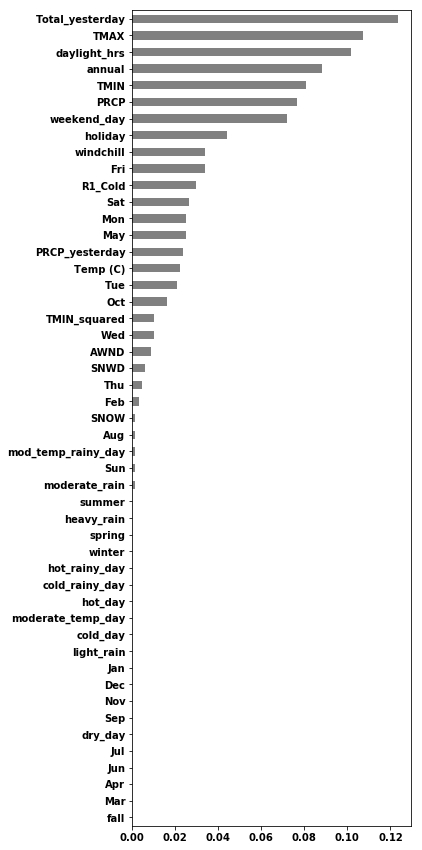

In [109]:
n = len(X_train.columns)
plt.figure(figsize=(5, 15))

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
top_n.plot.barh(color='gray');

### Permutation Importance

In [110]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [111]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
574.7498 ± 111.9470,weekend_day
106.0460 ± 20.8671,Total_yesterday
84.1965 ± 43.1469,TMAX
68.5747 ± 35.1800,PRCP
56.3539 ± 2.4530,Fri
36.8308 ± 1.6701,holiday
20.9573 ± 3.9601,Tue
19.6517 ± 7.0747,Sat
15.1869 ± 4.9781,TMIN
9.3176 ± 1.2503,Mon


### Using importances for feature selection

In [112]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (963, 49)


In [113]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (963, 18)


In [114]:
# Refit the model after removing features with zero importance

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 6)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BBCF7DD68>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023BBCEC47B8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [115]:
print('Mean Absolute Error:', -search.best_score_)

Mean Absolute Error: 275.5028549226026


In [116]:
best = search.best_estimator_
X_test = X_test[features]
y_pred = best.predict(X_test)

In [117]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.309368,0.059077,0.006400,0.001020,4,229,"{'max_depth': 4, 'n_estimators': 229}",-219.607332,-301.111787,-256.718028,...,-277.927305,52.484490,28,-84.703562,-80.269175,-84.078469,-79.532072,-83.714672,-82.459590,2.126015
1,0.200130,0.008944,0.003995,0.000633,2,64,"{'max_depth': 2, 'n_estimators': 64}",-235.444813,-356.206055,-275.697735,...,-308.785798,68.705509,99,-260.020978,-239.260313,-254.635481,-232.980796,-253.183688,-248.016251,10.172133
2,0.584431,0.010123,0.004574,0.000548,4,121,"{'max_depth': 4, 'n_estimators': 121}",-217.829810,-300.365783,-258.817842,...,-276.125977,53.390873,4,-127.473752,-116.590403,-124.355250,-117.810833,-122.619203,-121.769888,4.060559
3,0.177461,0.021000,0.005217,0.001153,2,70,"{'max_depth': 2, 'n_estimators': 70}",-232.562736,-355.764741,-270.258595,...,-304.462136,67.197303,98,-253.530307,-232.622948,-247.520431,-227.146839,-246.916471,-241.547399,9.951041
4,0.745225,0.023559,0.006605,0.002065,4,171,"{'max_depth': 4, 'n_estimators': 171}",-218.120096,-300.279712,-256.923984,...,-277.090737,53.375869,9,-104.454033,-96.449565,-103.264329,-96.697017,-101.833010,-100.539591,3.344060
5,1.119778,0.016376,0.006477,0.002208,4,264,"{'max_depth': 4, 'n_estimators': 264}",-219.912723,-301.113900,-256.532152,...,-278.212673,52.245513,38,-74.381291,-71.911773,-73.585541,-70.186522,-74.587773,-72.930580,1.664190
6,1.071997,0.020800,0.006116,0.001621,4,252,"{'max_depth': 4, 'n_estimators': 252}",-219.403978,-300.899473,-255.447733,...,-277.853076,52.486318,25,-78.321192,-75.641009,-76.407694,-73.543775,-77.925174,-76.367769,1.717329
7,0.993540,0.036702,0.006405,0.002150,5,166,"{'max_depth': 5, 'n_estimators': 166}",-236.463967,-294.242741,-263.371573,...,-278.250655,41.642792,40,-66.541381,-61.523024,-62.338787,-63.603797,-63.492602,-63.499918,1.703976
8,0.976239,0.045878,0.008194,0.004905,5,153,"{'max_depth': 5, 'n_estimators': 153}",-236.538346,-294.216741,-263.977960,...,-278.047932,41.379877,31,-71.102424,-66.411463,-66.063364,-67.753931,-68.789268,-68.024090,1.820969
9,1.672802,0.144778,0.010487,0.004469,5,180,"{'max_depth': 5, 'n_estimators': 180}",-236.344827,-294.132030,-263.792218,...,-278.461936,41.520943,51,-61.874818,-57.245324,-58.474630,-60.322462,-57.858485,-59.155144,1.705936


### Partial Dependence Plot

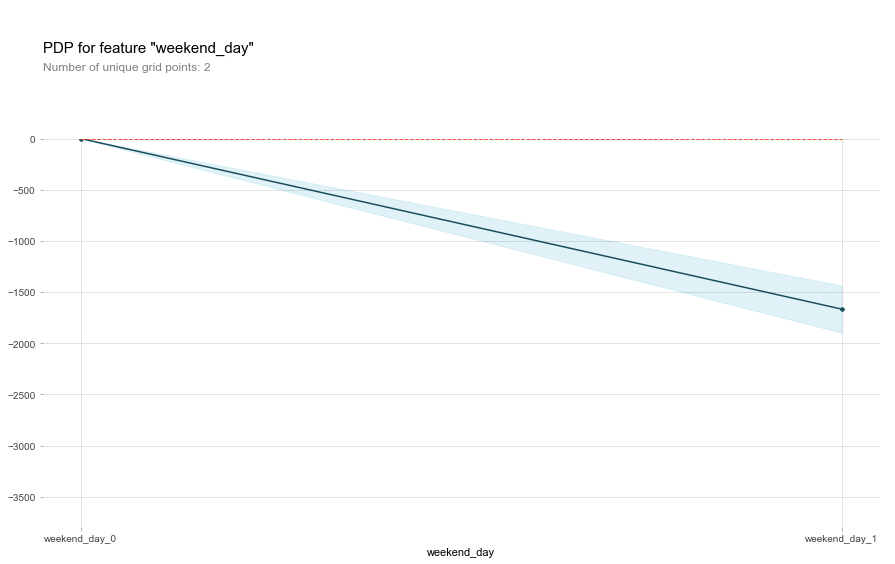

In [118]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'weekend_day'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

Exception ignored in: <function DMatrix.__del__ at 0x0000023BB7BB0E18>
Traceback (most recent call last):
  File "C:\Users\theta\Anaconda3\envs\lambda\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


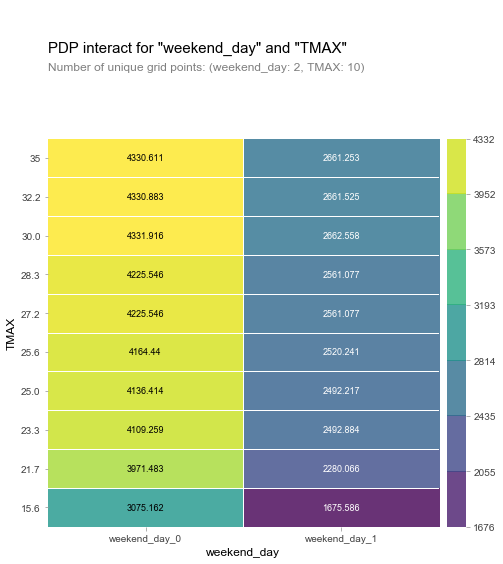

In [119]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['weekend_day', 'TMAX']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shaply Values

In [120]:
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
X_test = X_test.reset_index()
preds = preds.reset_index()
preds.head()

,index,y_test,y_pred
0,2015-05-25,1737.0,2130.129150
1,2015-05-26,4254.0,4313.204102
2,2015-05-27,4771.0,4710.479004
3,2015-05-28,5142.0,4807.241699
4,2015-05-29,4548.0,4735.135254


In [123]:
X_test.head()

,index,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,PRCP_yesterday,windchill,R1_Cold,May,Aug,weekend_day
0,2015-05-25,0.0,15.6,11.1,9.72,1776.0,1.0,0.0,0.0,0.0,0.0,1.0,15.269661,0.038307,26.334351,16.497583,1.0,0.0,False
1,2015-05-26,0.0,21.7,11.7,7.56,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,15.303607,0.000000,33.765185,15.719342,1.0,0.0,False
2,2015-05-27,0.0,24.4,11.7,6.48,4254.0,0.0,0.0,1.0,0.0,0.0,0.0,15.336561,0.000000,37.017100,15.262722,1.0,0.0,False
3,2015-05-28,0.0,27.8,12.2,7.56,4771.0,0.0,0.0,0.0,0.0,0.0,0.0,15.368497,0.000000,39.406801,15.885111,1.0,0.0,False
4,2015-05-29,0.0,26.1,12.8,9.00,5142.0,0.0,0.0,0.0,1.0,0.0,0.0,15.399396,0.000000,37.393796,16.453447,1.0,0.0,False


In [126]:
tp = preds.loc[(preds['y_pred'] > preds['y_test'].mean()) & (preds['y_test'] > preds['y_test'].mean())]
tp.sample(n=1)

,index,y_test,y_pred
92,2015-08-25,4473.0,4735.119629


In [129]:
data_for_prediction = X_test[X_test.index==92]
data_for_prediction = data_for_prediction.set_index('index')
data_for_prediction

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,PRCP_yesterday,windchill,R1_Cold,May,Aug,weekend_day
index,,,,,,,,,,,,,,,,,,
2015-08-25,0.0,25.6,12.2,12.24,4072.0,0.0,1.0,0.0,0.0,0.0,0.0,13.586282,0.0,34.461153,17.532693,0.0,1.0,False


In [130]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [131]:
fp = preds.loc[(preds['y_pred'] > preds['y_test'].mean()) & (preds['y_test'] < preds['y_test'].mean())]
fp.sample(n=1)

,index,y_test,y_pred
25,2015-06-19,3417.0,3856.450439


In [132]:
data_for_prediction = X_test[X_test.index==25]
data_for_prediction = data_for_prediction.set_index('index')
data_for_prediction

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,PRCP_yesterday,windchill,R1_Cold,May,Aug,weekend_day
index,,,,,,,,,,,,,,,,,,
2015-06-19,0.019685,23.9,13.3,11.52,4284.0,0.0,0.0,0.0,1.0,0.0,0.0,15.774432,0.0,34.33469,17.30295,0.0,0.0,False


In [133]:
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)